# **Pix2Pix (Image-to-Image Translation with Conditional Adversarial Nets) 실습**

## 학습목표

Image-to-Image Translation이라는 개념이 최초로 소개된 pix2pix 알고리즘을 구현해보고, Supervised Image-to-Image Translation의 특징에 대해 이해한다.

**목차(context)**
- pix2pix Dataset 알아보기
- pix2pix Training
- pix2pix Testing

> 이번 실습에서는 pix2pix 알고리즘을 직접 구현하는 실습을 진행한다. GAN을 활용한 Image-to-Image Translation 알고리즘에 대한 개념은 2016년 ‘Image-to-Image Translation with Conditional Adversarial Networks’ 라는 논문에서 최초로 제시되었다. 이 논문은 낮 이미지(영상)를 밤 이미지로 만들거나, 그 반대, 건물 이미지 생성, 열화상 이미지를 컬러 영상으로 변환 가능한 알고리즘을 제시했다. 위 알고리즘을 학습시키기 위해서는 원본 이미지와 변환시키고자 하는 많은 데이터 Pair 쌍이 필요하다. 학습 방법은 GAN 구조와 동일하게 Generator가 Discriminator를 속이도록 이미지를 생성하고 Discriminator는 Generator가 제작한 이미지(fake)와 Pair 쌍(real)를 구분할 수 있도록 학습하여, 결과물을(G(x)) 발전시키게 된다. 이는 Generator를 학습시킨 후 얻은 결과 이미지를 뜻한다.

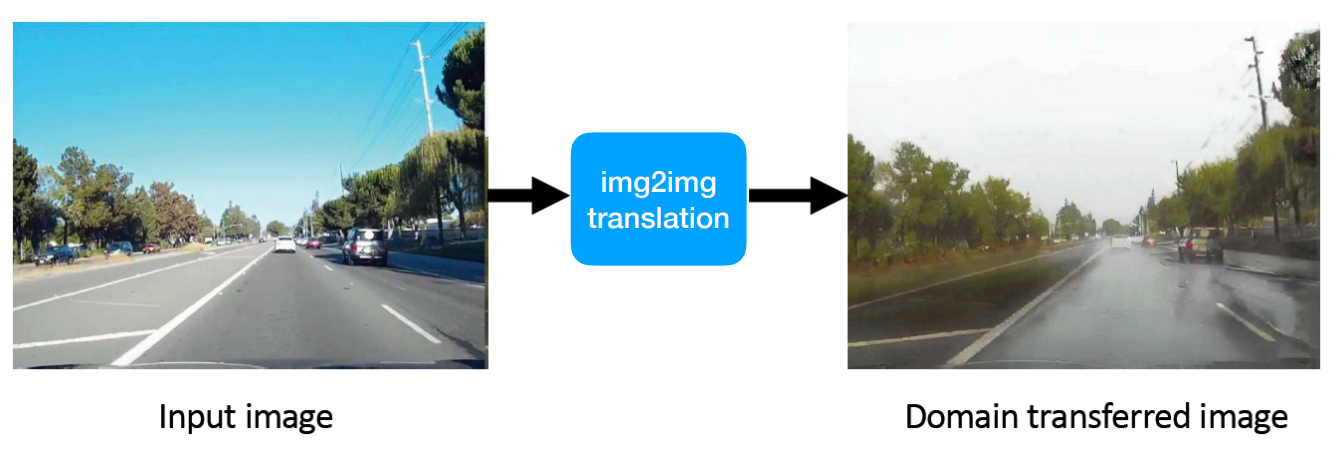


## 1. Import Packages

> 먼저, 필요한 package를 아래 코드를 사용하여 import 한다.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt
from math import log10

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import warnings
warnings.filterwarnings('ignore')

> 딥러닝 알고리즘을 training 하기 위해서는 GPU는 사실상 필수이다.

> GPU를 사용할 수 있도록 device를 할당한다. 빠른 학습을 위하여 반드시 하단 코드 출력값에 cuda가 표시되었는지 꼭 확인한다. (cpu가 뜨는 경우 런타임 유형을 GPU로 설정해야 한다. [런타임]-[런타임 유형] 메뉴에서 변경)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2. Facades Dataloader

> Facedes Dataset은 606개의 빌딩 사진과 이에 해당하는 Segmentation map이 포함되어 있는 Dataset이다. 이 Dataset을 편리하게 사용하기 위하여 DataLoader를 활용한다. Pair로 구성된 dataset을 학습에 사용하므로 Supervised Learning을 시행한다.

> 데이터셋을 다운 받는다.

In [3]:
!wget https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/facades.zip
!unzip -q facades.zip -d facades

--2024-09-24 05:17:11--  https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/facades.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35135868 (34M) [application/zip]
Saving to: ‘facades.zip’

facades.zip         100%[===================>]  33.51M  61.7MB/s    in 0.5s    

2024-09-24 05:17:12 (61.7 MB/s) - ‘facades.zip’ saved [35135868/35135868]



> MNIST 또는 CIFAR-10과 같이 torchvision 라이브러리에서 제공하지 않는 Dataset의 경우에는 직접 data.Dataset을 상속받아서 만들어야 한다. 이 때, `__init__`, `__getitem__`, `__len__` 은 항상 새로 정의해줘야 한다.

In [10]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, direction):
        super(DatasetFromFolder, self).__init__()
        self.direction = direction
        self.a_path = os.path.join(image_dir + "A") # a는 건물 사진
        self.b_path = os.path.join(image_dir + "B") # b는 Segmentation Mask
        self.image_filenames = [x for x in os.listdir(self.a_path)] # a 폴더에 있는 파일 목록
        self.image_filenames_b = [x.replace("A", "B") for x in self.image_filenames]
        self.transform = T.Compose([T.Resize((256, 256)),
                                    T.ToTensor(), # Tensor로 바꿔주는 함수를 사용
                                    T.Normalize(mean=(0.5, 0.5, 0.5),
                                                std=(0.5, 0.5, 0.5))])

    # getitem 함수: index에 맞는 data를 반환하는 역할
    def __getitem__(self, index):
        # a와 b 폴더에서 각각 건물 사진과 Segmentation Mask를 Load
        a = Image.open(os.path.join(self.a_path, self.image_filenames[index])).convert('RGB')
        b = Image.open(os.path.join(self.b_path, self.image_filenames_b[index])).convert('RGB')

        # a(건물사진)와 b(Segmentation Mask) 이미지를 각각 Resize를 하고, Tensor로 바꿔준다.
        a = self.transform(a)
        b = self.transform(b)

        if self.direction == "a2b":
            return a, b
        else:
            return b, a

    # len 함수는 Dataset 전체 개수를 반환한다.
    def __len__(self):
        return len(self.image_filenames)

In [13]:
import os
os.listdir('facades/facades')

['trainB', 'testA', 'testB', 'trainA']

> Dataloader를 선언한다.

In [11]:
train_set = DatasetFromFolder("facades/facades/train", "b2a")
test_set = DatasetFromFolder("facades/facades/test", "b2a")

# Training Set과 Test Set을 각각 DataLoader에 넣는다.
trainDataLoader = DataLoader(dataset=train_set, num_workers=4, batch_size=1, shuffle=True)
testDataLoader = DataLoader(dataset=test_set, num_workers=4, batch_size=1, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


> train 및 test Data를 시각화한 결과는 다음과 같다.

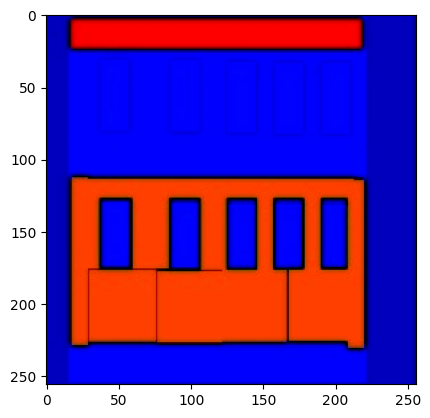

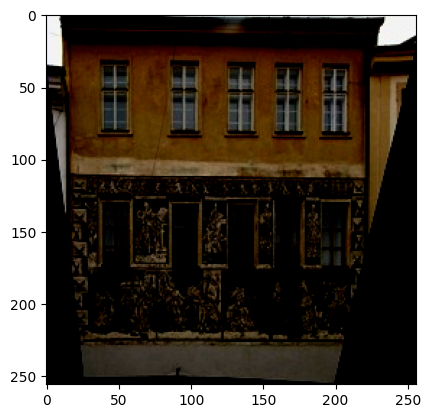

In [17]:
import torchvision.transforms.functional as TF
for i, (real_a, real_b) in enumerate(trainDataLoader, 1):
  imga = torch.squeeze(real_a[0])
  plt.imshow(TF.rotate(imga, 90).T)
  plt.show()

  imgb = torch.squeeze(real_b[0])
  plt.imshow(TF.rotate(imgb, 90).T)
  plt.show()

  break

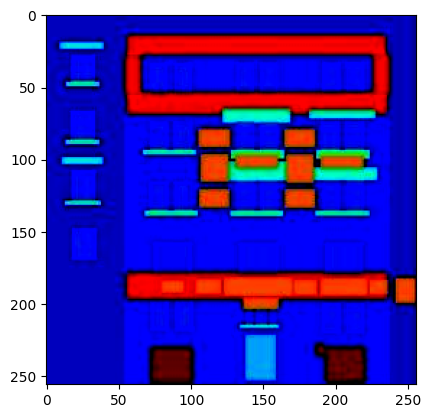

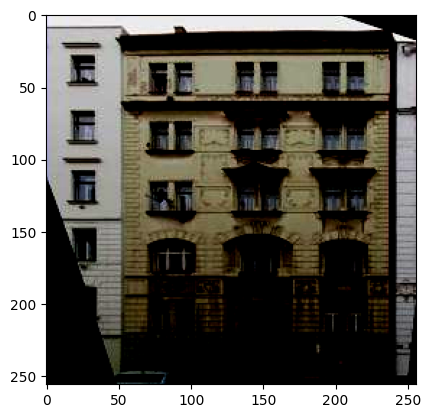

In [18]:
import torchvision.transforms.functional as TF
for i, (real_a, real_b) in enumerate(testDataLoader, 1):
  imga = torch.squeeze(real_a[0])
  plt.imshow(TF.rotate(imga, 90).T)
  plt.show()

  imgb = torch.squeeze(real_b[0])
  plt.imshow(TF.rotate(imgb, 90).T)
  plt.show()

  break

In [19]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def show_images(real_a, real_b, fake_b):
    plt.figure(figsize=(30,90))
    plt.subplot(131)
    plt.imshow(real_a.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(132)
    plt.imshow(real_b.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(133)
    plt.imshow(fake_b.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])

    plt.show()

## 3. U-Net Generator, Discriminator

> pix2pix는 encoder-decoder 구조를 구성할 때 U-Net을 사용한다. 이전 단원에서 학습했던 U-Net은 low level feature와 high level feature 모두를 전달하여, 기존의 encoder-decoder 구조와 비교할 때 superior한 결과를 보여준다.

> U-Net의 장점은 skip connection을 사용하여 low level feature가 hidden layer에 전달되도록 하여 low level feature 그리고 high level feature가 전부 사용될 수 있도록 하는 것이다.



> **conv 함수**: 코드 단순화를 위한 convolution block 생성을 위한 함수이다. Conv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성한다.

> **deconv 함수**: 코드 단순화를 위한 deconvolution block 생성을 위한 함수이다. Deconv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성한다.



In [20]:
def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    layers = []

    # Conv 과정
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))

    # Batchnorm 과정
    if bn:
        layers.append(nn.BatchNorm2d(c_out))

    # Activation 과정
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass

    return nn.Sequential(*layers)

def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    layers = []

    # Deconv 과정
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))

    # Batchnorm 과정
    if bn:
        layers.append(nn.BatchNorm2d(c_out))

    # Activation 과정
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass

    return nn.Sequential(*layers)

> `conv`, `deconv` 는 U-Net에서의 encoder, decoder에 사용됩니다. 구체적으로, `conv`는 U-Net encoder에서 convolution block을 제작하는 과정에서 활용되며, `deconv`는 U-Net decoder에서 이미지 복원을 위한 용도로 사용됩니다.



In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Unet encoder 설정
        self.conv1 = conv(3, 64, 4, bn=False, activation='lrelu') # (B, 64, 128, 128)
        self.conv2 = conv(64, 128, 4, activation='lrelu') # (B, 128, 64, 64)
        self.conv3 = conv(128, 256, 4, activation='lrelu') # (B, 256, 32, 32)
        self.conv4 = conv(256, 512, 4, activation='lrelu') # (B, 512, 16, 16)
        self.conv5 = conv(512, 512, 4, activation='lrelu') # (B, 512, 8, 8)
        self.conv6 = conv(512, 512, 4, activation='lrelu') # (B, 512, 4, 4)
        self.conv7 = conv(512, 512, 4, activation='lrelu') # (B, 512, 2, 2)
        self.conv8 = conv(512, 512, 4, bn=False, activation='relu') # (B, 512, 1, 1)

        # Unet decoder 설정
        self.deconv1 = deconv(512, 512, 4, activation='relu') # (B, 512, 2, 2)
        self.deconv2 = deconv(1024, 512, 4, activation='relu') # (B, 512, 4, 4)
        self.deconv3 = deconv(1024, 512, 4, activation='relu') # (B, 512, 8, 8) # Hint : U-Net에서는 Encoder에서 넘어온 Feature를 Concat한다. (Channel이 2배)
        self.deconv4 = deconv(1024, 512, 4, activation='relu') # (B, 512, 16, 16)
        self.deconv5 = deconv(1024, 256, 4, activation='relu') # (B, 256, 32, 32)
        self.deconv6 = deconv(512, 128, 4, activation='relu') # (B, 128, 64, 64)
        self.deconv7 = deconv(256, 64, 4, activation='relu') # (B, 64, 128, 128)
        self.deconv8 = deconv(128, 3, 4, activation='tanh') # (B, 3, 256, 256)

    def forward(self, input):
        # Unet encoder forward 메서드
        e1 = self.conv1(input)
        e2 = self.conv2(e1)
        e3 = self.conv3(e2)
        e4 = self.conv4(e3)
        e5 = self.conv5(e4)
        e6 = self.conv6(e5)
        e7 = self.conv7(e6)
        e8 = self.conv8(e7)

        # Unet decoder forward 메서드
        d1 = F.dropout(self.deconv1(e8), 0.5, training=True)
        d2 = F.dropout(self.deconv2(torch.cat([d1, e7], 1)), 0.5, training=True)
        d3 = F.dropout(self.deconv3(torch.cat([d2, e6], 1)), 0.5, training=True)
        d4 = self.deconv4(torch.cat([d3, e5], 1))
        d5 = self.deconv5(torch.cat([d4, e4], 1))
        d6 = self.deconv6(torch.cat([d5, e3], 1))
        d7 = self.deconv7(torch.cat([d6, e2], 1))
        output = self.deconv8(torch.cat([d7, e1], 1))
        output = F.tanh(output)

        return output

> pix2pix의 Discriminator는 conditional Discriminator로 주어진 조건에 따라 입력 이미지의 real/fake를 판별할 수 있도록 구성된다.

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = conv(6, 64, 4, bn=False, activation='lrelu')
        self.conv2 = conv(64, 128, 4, activation='lrelu')
        self.conv3 = conv(128, 256, 4, activation='lrelu')
        self.conv4 = conv(256, 512, 4, 1, 1, activation='lrelu')
        self.conv5 = conv(512, 1, 4, 1, 1, activation='none')

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = torch.sigmoid(self.conv5(out))

        return out

D = Discriminator()
for i, (real_a, real_b) in enumerate(trainDataLoader, 1):
  real_ab = torch.cat((real_a, real_b), 1)
  pred_real = D.forward(real_ab)
  real_label = torch.ones(1)

In [23]:
G = Generator().to(device)
D = Discriminator().to(device)

## 4. Training pix2pix

In [24]:
criterionL1 = nn.L1Loss().cuda()
criterionMSE = nn.MSELoss().cuda()

# optimizer 세팅
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

D_loss_data = []
G_loss_data = []

# Training 코드
for epoch in range(1, 200):
    for i, (real_a, real_b) in enumerate(trainDataLoader, 1):
        real_a, real_b = real_a.cuda(), real_b.cuda()
        real_label = torch.ones(1).cuda()
        fake_label = torch.zeros(1).cuda()

        fake_b = G(real_a)

        #============= Discriminator 학습 =============#
        # fake 학습
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab.detach())
        loss_d_fake = criterionMSE(pred_fake, fake_label)

        # real 학습
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = D.forward(real_ab)
        loss_d_real = criterionMSE(pred_real, real_label)

        # D loss 결합 (Fake + Real)
        loss_d = (loss_d_fake + loss_d_real) * 0.5

        # Backprop + Optimize 과정
        D.zero_grad()
        loss_d.backward()
        d_optimizer.step()

        #============= Generator 학습 =============#
        # 1. G(A) 가 Discriminator를 속이도록
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab)
        loss_g_gan = criterionMSE(pred_fake, real_label)

        # 2. G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * 10

        loss_g = loss_g_gan + loss_g_l1

        # Backprop + Optimize 과정
        G.zero_grad()
        D.zero_grad()
        loss_g.backward()
        g_optimizer.step()

        if i % 200 == 0:
            print('======================================================================================================')
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f'
                  % (epoch, 200, i+1, len(trainDataLoader), loss_d.item(), loss_g.item()))
            D_loss_data.append(float(loss_d.item()))
            G_loss_data.append(float(loss_g.item()))
            print('======================================================================================================')
            show_images(denorm(real_a.squeeze()), denorm(real_b.squeeze()), denorm(fake_b.squeeze()))

Output hidden; open in https://colab.research.google.com to view.

> 200 Step 만큼씩 pix2pix Training 결과를 출력한 이미지는 상단과 같다.

## 5. Test pix2pix

> PSNR과 SSIM은 이미지 퀄리티 평가 측면에서 유명한 평가지표(Evaluation Metric) 이다. 즉, PSNR은 Peak Signal-to-Noise Ratio의 줄임말로, 생성 혹은 압축이 된 영상 화질에 대하여 손실 정보를 평가하는 평가 지표이다.

> PSNR을 활용하여 test dataset을 평가해 보자.

In [25]:
avg_psnr = 0
for (real_a, real_b) in testDataLoader:
    real_a, real_b = real_a.cuda(), real_b.cuda()
    fake_b = G(real_a)

    mse = criterionMSE(fake_b, real_b)
    psnr = 10 * log10(1 / mse.item())
    avg_psnr += psnr
print("Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testDataLoader)))

Avg. PSNR: 7.5604 dB


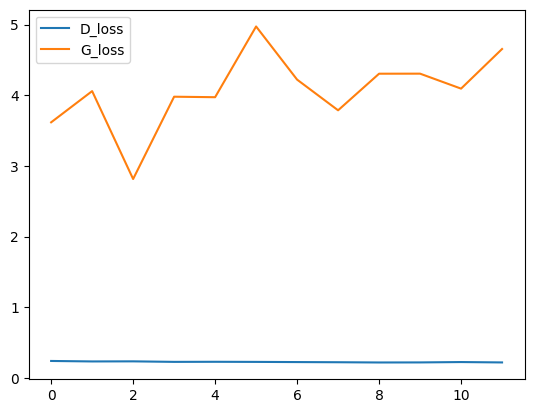

In [26]:
plt.plot(D_loss_data, label='D_loss')
plt.plot(G_loss_data, label='G_loss')
plt.legend()
plt.show()

> Discriminator와 Generator loss를 plot한 결과는 위와 같다.

In [ ]:
!mkdir model
torch.save(G.state_dict(), "model/pix2pix_generator.pckl")
torch.save(D.state_dict(), "model/pix2pix_discriminator.pckl")